In [2]:
# Imports
from config import ds_config
from fastai.vision.all import *
from fastai.callback.tensorboard import TensorBoardCallback
import torchvision.transforms.functional as transformF

# from fastai.callback.tracker import
from fastai.vision.widgets import *
import os
import matplotlib.pyplot as plt
from IPython.display import Image
import argparse as ap
import datetime
import gc
from tqdm import tqdm
from multiprocessing import set_start_method

from utils import *  # import utils at the end after fastai because the Hook function is a monkey-patch

os.environ["TORCH_HOME"] = "/media/hdd/Datasets/"
os.environ["FASTAI_HOME"] = "/media/hdd/Datasets/"

# set_start_method('spawn')
# Monkey patch batch prediction (fastai does not have this by default)
Learner.predict_batch = predict_batch

In [5]:
# ags = ap.ArgumentParser("Additional Arguments for CLI")
# ags.add_argument(
#     "--config", help="Name of config from dictionary", default="fish_test_proxy"
# )
# ags.add_argument("--name", help="Name of the experiment", required=True)
# args = ags.parse_args()
args = {
    "config": "fish_test_proxy",
    "name" : "testing_ugh"
}
from types import SimpleNamespace
args = SimpleNamespace(**args)
ds_meta = ds_config[args.config]  # get info about dataset from the config file

In [6]:
# Training Part 1
path = Path(ds_meta["ds_path"])
fname_start = f'{ds_meta["ds_name"]}_{args.name}_{datetime.now().strftime("%d%m%Y_%H:%M:%S")}'  # unique_name
print(f"[INFO] : File name = {fname_start}")

# Check if directories all present
create_if_not_exists(f"tb_runs/{fname_start}")
create_if_not_exists(f"csv_logs/{fname_start}")
# Remove previous files

all_files = get_image_files(path)
[Path.unlink(file) for file in all_files if "augmented_" in file.name]
print("[INFO] : Removed Old augmented files")

# TODO : Add reset folder

[INFO] : File name = fish_testing_ugh_10102022_00:38:33
[INFO] : Removed Old augmented files


In [7]:
batch_tfms = aug_transforms() if ds_meta["enable_default_augments"] == True else None
fields = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    get_y=ds_meta["name_fn"],
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    item_tfms=RandomResizedCrop(ds_meta["image_size"], min_scale=0.5),
    batch_tfms=batch_tfms,
)
# Metrics
metrics = [accuracy, error_rate]
# Callbacks

In [8]:
# MAIN LOOP
training_rounds = ds_meta["epoch_steps"]
total_epochs = sum(training_rounds)  # total no of epochs

# Convert [1,2,3] -> [1,'aug', 2, 'aug', 3, 'aug']
[training_rounds.insert(2 * x, "aug") for x in range(len(training_rounds))]
training_rounds.pop(0)
print(f"[LOG] Training rounds scheme : {training_rounds}")

# Start the loop
total_epochs_passed = 0


[LOG] Training rounds scheme : [1, 'aug', 2]


  0%|          | 0/3 [00:00<?, ?it/s]/home/eragon/micromamba/envs/pytorcher/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/home/eragon/micromamba/envs/pytorcher/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


epoch,train_loss,valid_loss,accuracy,error_rate,time
0,2.207286,1.329824,0.503056,0.496944,00:27


epoch,train_loss,valid_loss,accuracy,error_rate,time
0,1.350487,0.895732,0.658333,0.341667,00:39


 33%|███▎      | 1/3 [01:15<02:30, 75.14s/it]

[LOG] : Cleared learner
[INFO]: Running Proxy Attention
[INFO] : Starting Attention Loop


[INFO] : Pct wrong for step 1 = 0.3472222222222222
[INFO] : Creating maps


/home/eragon/micromamba/envs/pytorcher/lib/python3.10/site-packages/torch/nn/modules/module.py:1053: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
 33%|███▎      | 1/3 [03:46<07:32, 226.35s/it]


KeyboardInterrupt: 

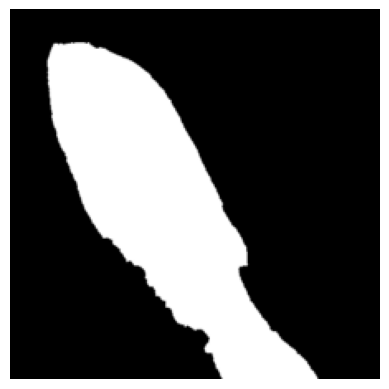

In [9]:

for i, step in tqdm(enumerate(training_rounds), total=len(training_rounds)):
    if i == 0:
        # Initialize everything with new or old data
        dls = fields.dataloaders(path, bs=ds_meta["batch_size"])
        cbs = [
            TensorBoardCallback(
                log_dir=f"tb_runs/{fname_start}", projector=False, trace_model=False
            ),
            CSVLogger(fname=f"csv_logs/{fname_start}.csv"),
        ]

        learn = vision_learner(
            dls, ds_meta["network"], cbs=cbs, metrics=metrics, pretrained=ds_meta["pretrained"]
        ).to_fp16()
        fname_training = f'{ds_meta["ds_name"]}_{args.name}_{datetime.now().strftime("%d%m%Y_%H:%M:%S")}'  # unique_name
        learn.fine_tune(step)
        learn.save("temp_model")  # saving so can be reloaded
        clear_learner(learn, dls)
        print("[LOG] : Cleared learner")
        # Since training is in batches, keep track of total no of epochs trained for
        total_epochs_passed += step

    if step != "aug" and i > 0:
        # Initialize everything with new or old data
        dls = fields.dataloaders(path, bs=ds_meta["batch_size"])
        cbs = [
            TensorBoardCallback(
                log_dir=f"tb_runs/{fname_start}", projector=False, trace_model=False
            ),
            CSVLogger(fname=f"csv_logs/{fname_start}.csv"),
        ]

        learn = vision_learner(
            dls, ds_meta["network"], cbs=cbs, metrics=metrics, pretrained=ds_meta["pretrained"]
        ).to_fp16()

        learn.load("temp_model")  # load model since augment has been done already
        # Continue training
        fname_training = f'{ds_meta["ds_name"]}_{args.name}_{datetime.now().strftime("%d%m%Y_%H:%M:%S")}'  # unique_name
        learn.fine_tune(step)
        learn.save("temp_model")
        clear_learner(learn, dls)

        print("[LOG] : Cleared learner")
        # Since training is in batches, keep track of total no of epochs trained for
        total_epochs_passed += step
    if step == "aug":
        if ds_meta["enable_proxy_attention"] == True:
            print("[INFO]: Running Proxy Attention")

            # PROXY ATTENTION LOOP

            dls = fields.dataloaders(path, bs=ds_meta["batch_size"])
            cbs = [
                TensorBoardCallback(
                    log_dir=f"tb_runs/{fname_start}", projector=False, trace_model=False
                ),
                CSVLogger(fname=f"csv_logs/{fname_start}.csv"),
            ]

            learn = vision_learner(
                dls, ds_meta["network"], cbs=cbs, metrics=metrics, pretrained=ds_meta["pretrained"]
            ).to_fp16()

            learn.load("temp_model")  # load model since augment has been done already
            learn.to('cpu')

            # Get the classes
            print("[INFO] : Starting Attention Loop")
            vocab_dict = {
                learn.dls.vocab[x]: x for x in range(len(learn.dls.vocab))
            }  # Get class names
            # Get images, shuffle, pick a subset
            items = get_image_files_exclude_augment(ds_meta["ds_path"])
            # items = items.shuffle()
            subset = int(ds_meta["change_subset_attention"] * len(items))
            items = items[:subset]
            # Get preds from the network for all the chosen images with "num_workers" threads
            bspred = learn.predict_batch(items, num_workers=10)
            # Get all the class names for the subset of images and convert them into the One hot encoded version that the network knows already
            item_names = list(
                map(lambda x: vocab_dict[x], list(map(ds_meta["name_fn"], items)))
            )

            # Get the index of all the images that the network predicted wrong
            # TODO : Check for confidence
            index_wrongs = [
                x for x in range(subset) if bspred[2][x] != TensorBase(item_names)[x]
            ]
            print(
                f"[INFO] : Pct wrong for step {total_epochs_passed} = {len(index_wrongs)/len(bspred[2])}"
            )

            # RUN PROXY ATTENTION
            print(f"[INFO] : Creating maps")
            # def create_im(im):
            #     img = PILImage.create(items[im])

            #     (x,) = first(dls.test_dl([img]))

            #     x_dec = TensorImage(dls.train.decode((x,))[0][0])

            #     # Get attention maps

            #     # -----
            #     # Grad CAM Attention map
            #     cls = 1
            #     try:
            #         with HookBwd(learn.model[-2][4][-1]) as hookg:  # for other layers
            #             with Hook(learn.model[-2][4][-1]) as hook:
            #                 output = learn.model.eval()(x.cuda())
            #                 act = hook.stored
            #             output[0, cls].backward()
            #             grad = hookg.stored
            #         w = grad[0].mean(dim=[1, 2], keepdim=True)
            #         cam_map = (w * act[0]).sum(0)
            #         # print(x.shape,x_dec.shape, w.shape, cam_map.shape)

            #     except Exception as e:
            #         print(e)
            #     # -----

            #     # test_cam_map = cam_map.detach().cpu()
            #     # Resize cam map so it's the same size as the image, as the output is much smaller
            #     t_resized = transformF.resize(
            #         torch.unsqueeze(cam_map, 0), ds_meta["image_size"]
            #     )
            #     t_resized = (
            #         torch.cat([t_resized, t_resized, t_resized], dim=0).detach().cpu()
            #     )

            #     # IMPORTANT : Change the pixels that are of higher intensity to 0 because they did not help the network get the right answer
            #     x_dec[t_resized >= 0.009] = 0.0

            #     x_dec = torch.einsum("ijk->jki", x_dec)
            #     plt.imshow(x_dec)
            #     plt.axis("off")
            #     plt.spines['top'].set_visible(False)
            #     plt.spines['right'].set_visible(False)
            #     plt.spines['bottom'].set_visible(False)
            #     plt.spines['left'].set_visible(False)
            #     plt.box(False)
            #     plt.savefig(rename_for_aug(items[im]), transparent = True)

            # parallel(create_im, index_wrongs, progress=True, n_workers=8)
            for im in tqdm(index_wrongs, total = len(index_wrongs)):
                img = PILImage.create(items[im])

                (x,) = first(dls.test_dl([img]))

                x_dec = TensorImage(dls.train.decode((x,))[0][0])

                # Get attention maps

                # -----
                # Grad CAM Attention map
                cls = 1
                try:
                    with HookBwd(learn.model[-2][4][-1]) as hookg:  # for other layers
                        with Hook(learn.model[-2][4][-1]) as hook:
                            output = learn.model.eval()(x.cuda())
                            act = hook.stored
                        output[0, cls].backward()
                        grad = hookg.stored
                    w = grad[0].mean(dim=[1, 2], keepdim=True)
                    cam_map = (w * act[0]).sum(0)
                    # print(x.shape,x_dec.shape, w.shape, cam_map.shape)

                except Exception as e:
                    print(e)
                # -----

                # test_cam_map = cam_map.detach().cpu()
                # Resize cam map so it's the same size as the image, as the output is much smaller
                t_resized = transformF.resize(
                    torch.unsqueeze(cam_map, 0), ds_meta["image_size"]
                )
                t_resized = (
                    torch.cat([t_resized, t_resized, t_resized], dim=0).detach().cpu()
                )

                # IMPORTANT : Change the pixels that are of higher intensity to 0 because they did not help the network get the right answer
                x_dec[t_resized >= 0.008] = 0.0

                x_dec = torch.einsum("ijk->jki", x_dec)
                plt.imshow(x_dec)
                plt.axis("off")
                plt.box(False)
                plt.savefig(rename_for_aug(items[im]), transparent = True)


            clear_learner(learn, dls)
            del bspred
            del items
            # del t_resized
            gc.collect()

    # Save model every n epochs
    if total_epochs_passed % ds_meta["save_model_every_n_epoch"] == 0:
        learn.save(fname_training)